In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
        
import matplotlib as mpl
%matplotlib inline
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from PIL import Image
from IPython.display import Image as Imgdisplay

import glob
import argparse
import os

import shutil
import psutil
from pathlib import Path

from trend_labeling import seq_seq_trend
from candlechart4ML import candlechart_generator

In [2]:
def removeOutput(filepath):
    if(Path(filepath)).is_file():
        os.remove(filepath)
    
def csv_initiator(market, ticker, head_date, tail_date):
    df = fdr.DataReader(ticker, head_date, tail_date, exchange=market)
    
    filedir = os.getcwd() + '\\dataset\\raw_data\\'
    filename = "{}_{}.csv".format(market, ticker)    
    filepath = filedir + filename
    
    if not os.path.exists(filedir):
        os.makedirs(filedir)    
    removeOutput(filepath)
    df.to_csv(filepath)
    
    print("csv file saved as : {}".format(filepath))
    
    return filepath

In [3]:
# main
market = 'KRX'
ticker = '005930'
seq_len = 20
tre_len = 20
head_date = '2000-01-01'
tail_date = '2022-01-01'
dimension = 60
use_volume = False

data_csv_path = csv_initiator(market, ticker, head_date, tail_date)
label_set_path = seq_seq_trend(data_csv_path, seq_len=seq_len, tre_len=tre_len)
candlechart_dir = candlechart_generator(data_csv_path, seq_len=seq_len, tre_len=tre_len, dimension=dimension, use_volume=use_volume)

csv file saved as : C:\Users\SeungHyuck\Documents\github_remote\AI-Trade\ML Quant Strategy\CandleChart_Binary_Classifier\dataset\raw_data\KRX_005930.csv
Creating label . . .
type : Sequence to Sequence
sequence_length : 20, trend_sequence_length : 20, gap : 0
Create label finished.
Converting ohlc to candlestick
Converting finished


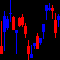

In [4]:
Imgdisplay(candlechart_dir + os.listdir(candlechart_dir)[0], height=180, width=180) # 생성된 캔들차트 샘플확인

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [11]:
# 캔들차트이미지를 데이터 셋으로
# 한 픽셀의 RGB 값, 한 변의 픽셀 수는 dimension
def image2dataarray(candlechart_dir):
    symbol = candlechart_dir.split('\\')[-3]
    imgs = list([])
    for i in range(len(os.listdir(candlechart_dir))):
        imgname = '{}-{}.png'.format(symbol, i)
        im = Image.open(candlechart_dir+imgname)
        pixels = list(im.getdata())
        img = list([])
        for pixel in pixels:
            for j in range(3): # Excepting alpha value
                img.append(pixel[j])
        imgs.append(img)
        # print(imgs)
    return np.array(imgs)

def label2dataarray(label_set_path):
    label_array = list([])
    with open(label_set_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            label = int(line.split(',')[-1])
            label_array.append(label)
        return np.array(label_array)

In [12]:
candle_array = image2dataarray(candlechart_dir)
label_array = label2dataarray(label_set_path)
print(len(candle_array), len(label_array))

5389 5389


In [13]:
X_all = candle_array
y_all = label_array

slicer = int(0.8 * len(candle_array))

X_train, y_train = X_all[:slicer], y_all[:slicer]
X_test, y_test = X_all[slicer:], y_all[slicer:]

In [71]:
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
params = {
    'sgc__loss'    : ['hinge'],
    'sgc__penalty' : ['l1', 'l2', 'elasticnet'],
    'sgc__alpha'   : [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
}

sgd_cla_pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("sgc", SGDClassifier(random_state=42))
])

sgd_cla_CV = GridSearchCV(sgd_cla_pipe, param_grid=params, cv=my_cv, n_jobs=-1)
sgd_cla_CV.fit(X_train, y_train)

print("best parameter :\n", sgd_cla_CV.best_params_)
print("best prediction: {0:.4f}".format(sgd_cla_CV.best_score_))
print("train set score: {0:.7f}".format(sgd_cla_CV.score(X_train, y_train))) # 훈련세트 점수
print(" test set score: {0:.7f}".format(sgd_cla_CV.score(X_test, y_test))) # 검증세트 점수
print(sgd_cla_CV.cv_results_)

best parameter :
 {'sgc__alpha': 0.1, 'sgc__loss': 'hinge', 'sgc__penalty': 'elasticnet'}
best prediction: 0.7292
train set score: 0.7661795
 test set score: 0.7207792
{'mean_fit_time': array([ 9.70479522,  5.96559711,  9.8221952 ,  9.73659554,  5.02959714,
        8.66149583,  6.59529653,  5.02729731,  8.421596  ,  5.67299676,
        5.00379739,  9.08889532,  6.71589675,  5.07309756,  7.91879554,
       43.03097839,  5.29699712,  7.33589659, 68.10676599,  4.25589757,
        8.7895957 , 26.96848655,  4.89819746,  7.0336967 ,  3.17549853,
        4.96579738,  4.43939753,  2.73719935,  3.62419891,  3.37909842,
        3.11409855,  3.06059804,  3.39749866,  3.55989842,  3.42689772,
        3.20849891,  3.51419811,  2.90109849,  3.38029833,  3.26349812,
        2.75599847,  2.50789876]), 'std_fit_time': array([ 5.31214057,  2.6864144 ,  5.31201819,  5.5769115 ,  2.66137492,
        5.8358243 ,  4.00430274,  3.22986239,  5.74962597,  3.12237466,
        3.11180926,  6.04477861,  4.7944216

In [72]:
cv_result_df = pd.DataFrame(sgd_cla_CV.cv_results_)
cv_result_df.to_csv("result.txt")
cv_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgc__alpha,param_sgc__loss,param_sgc__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.704795,5.312141,0.210300,0.053481,0.0,hinge,l1,"{'sgc__alpha': 1e-08, 'sgc__loss': 'hinge', 's...",0.715877,0.629526,0.629526,0.644847,0.713092,0.666574,0.039527,16
1,5.965597,2.686414,0.194800,0.047855,0.0,hinge,l2,"{'sgc__alpha': 1e-08, 'sgc__loss': 'hinge', 's...",0.714485,0.636490,0.621170,0.636490,0.714485,0.664624,0.041094,22
2,9.822195,5.312018,0.183600,0.032952,0.0,hinge,elasticnet,"{'sgc__alpha': 1e-08, 'sgc__loss': 'hinge', 's...",0.714485,0.632312,0.629526,0.646240,0.715877,0.667688,0.039192,13
3,9.736596,5.576912,0.191800,0.045787,0.0,hinge,l1,"{'sgc__alpha': 1e-07, 'sgc__loss': 'hinge', 's...",0.710306,0.646240,0.646240,0.644847,0.700557,0.669638,0.029392,8
4,5.029597,2.661375,0.154900,0.023202,0.0,hinge,l2,"{'sgc__alpha': 1e-07, 'sgc__loss': 'hinge', 's...",0.717270,0.621170,0.633705,0.642061,0.720056,0.666852,0.042832,14
5,8.661496,5.835824,0.168400,0.007971,0.0,hinge,elasticnet,"{'sgc__alpha': 1e-07, 'sgc__loss': 'hinge', 's...",0.717270,0.655989,0.640669,0.646240,0.722841,0.676602,0.035861,6
6,6.595297,4.004303,0.179600,0.020318,0.000001,hinge,l1,"{'sgc__alpha': 1e-06, 'sgc__loss': 'hinge', 's...",0.711699,0.635097,0.626741,0.653203,0.707521,0.666852,0.035969,15
7,5.027297,3.229862,0.157200,0.017354,0.000001,hinge,l2,"{'sgc__alpha': 1e-06, 'sgc__loss': 'hinge', 's...",0.703343,0.640669,0.630919,0.660167,0.713092,0.669638,0.033022,8
8,8.421596,5.749626,0.194399,0.026499,0.000001,hinge,elasticnet,"{'sgc__alpha': 1e-06, 'sgc__loss': 'hinge', 's...",0.703343,0.646240,0.632312,0.639276,0.711699,0.666574,0.033825,16
9,5.672997,3.122375,0.180500,0.015159,0.00001,hinge,l1,"{'sgc__alpha': 1e-05, 'sgc__loss': 'hinge', 's...",0.713092,0.639276,0.636490,0.651811,0.692201,0.666574,0.030623,16


In [69]:
unique, counts = np.unique(sgd_cla_CV.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[532 546]


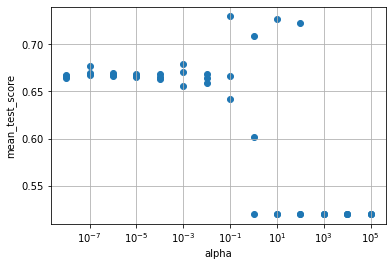

In [73]:
fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean_test_score')
plt.grid('True')
x=sgd_cla_CV.cv_results_['param_sgc__alpha']
y=sgd_cla_CV.cv_results_['mean_test_score']
ax.scatter(x, y)
plt.show()

In [21]:
randf_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("randf", RandomForestClassifier()),
            ])
randf_cla.fit(X_train, y_train)
print("train_set score: ", randf_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", randf_cla.score(X_test, y_test)) # 검증세트 점수

train_set score:  1.0
test_set score :  0.49878345498783455


In [22]:
unique, counts = np.unique(randf_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[236 175]


In [80]:
ada_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("ada", AdaBoostClassifier()),
            ])
ada_cla.fit(X_train, y_trai1n)
print("train_set score: ", randf_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", randf_cla.score(X_test, y_test)) # 검증세트 점수

train_set score:  1.0
test_set score :  0.5085158150851582


In [81]:
unique, counts = np.unique(ada_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[219 192]


In [27]:
svm_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("svc", SVC()),
            ])
svm_cla.fit(X_train, y_train)
print("train_set score: ", svm_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", svm_cla.score(X_test, y_test)) # 검증세트 점수

train_set score:  0.9666666666666667
test_set score :  0.4801980198019802


In [28]:
unique, counts = np.unique(svm_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[ 99 103]
